In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import pickle
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

Set paths, import data:

In [3]:
path_data = "C:/Users/NORA/hlca_core.h5ad"
path_results = "Exploration_results/"

In [4]:
adata = anndata.read_h5ad(path_data, backed = 'r')

if not os.path.exists(path_results):
    os.makedirs(path_results)

### UMAP Sanity Check

Color by cell type:

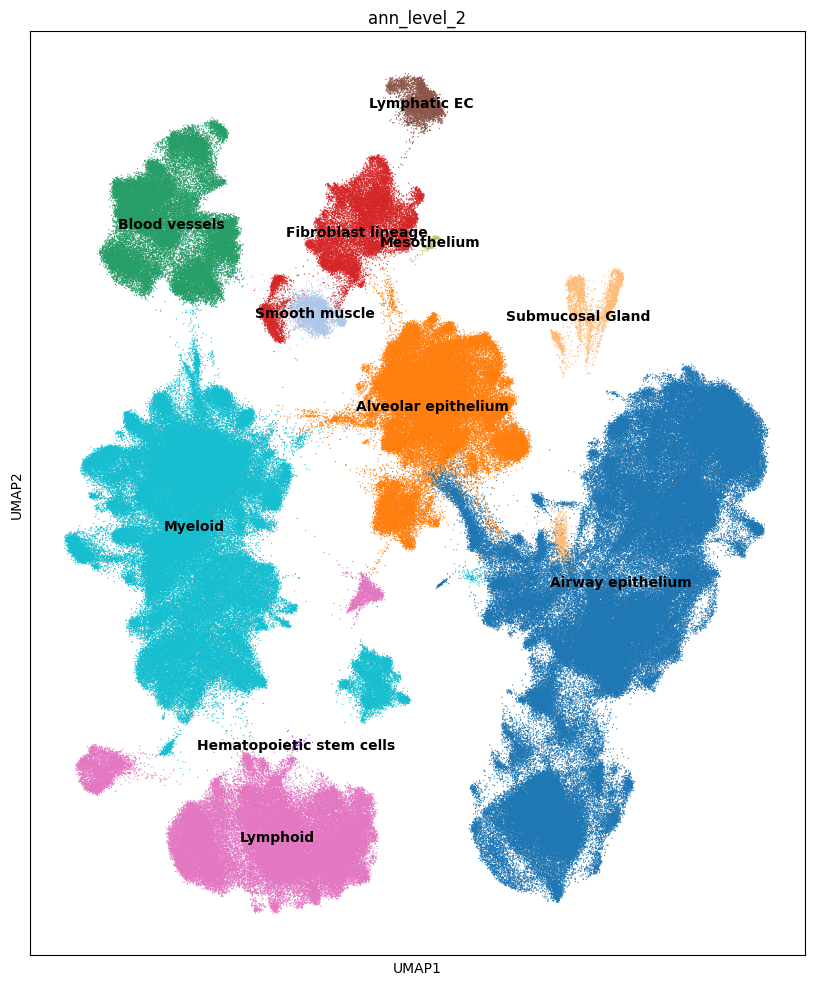

In [5]:
plt.rcParams["figure.figsize"] = [10,12]

sc.pl.umap(adata, color="ann_level_2", legend_loc="on data", legend_fontsize=10, size=3)
plt.show()

Color by sex:

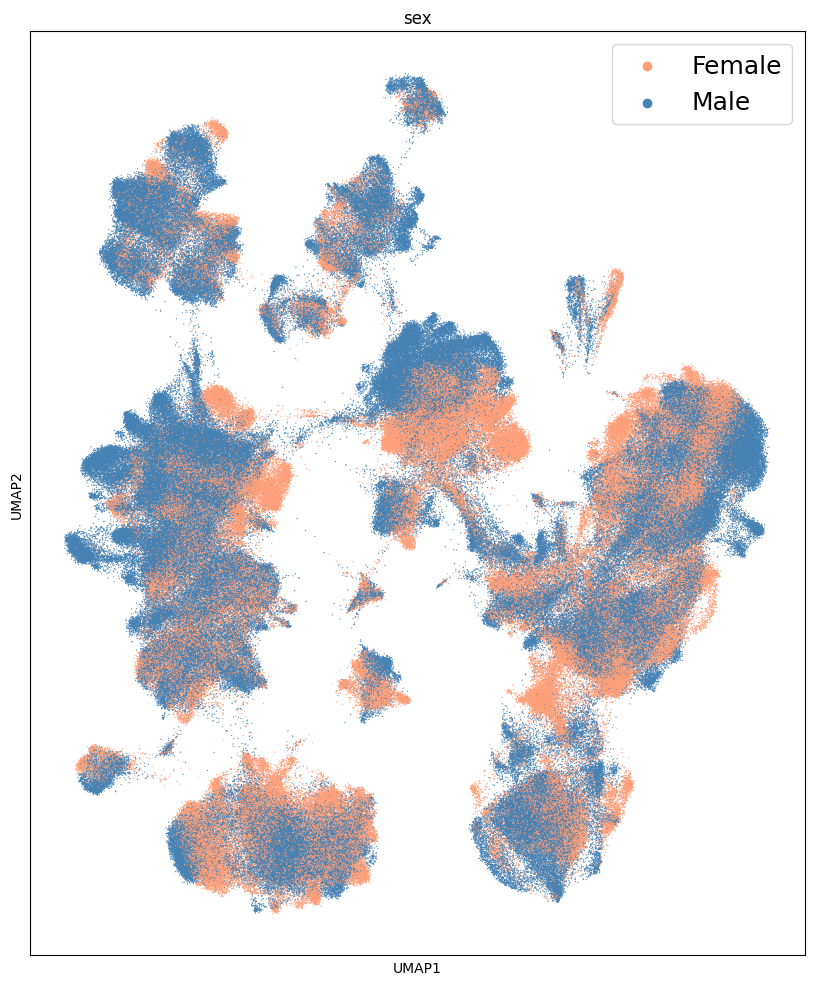

In [6]:
sex_color_map = {'male': 'steelblue', 'female': 'lightsalmon'}

sc.pl.umap(adata, color="sex", size=3, palette=sex_color_map, show = False)

legend = plt.legend(loc='upper right', bbox_to_anchor=(1, 1), framealpha = 0.8, fontsize=18)
legend = plt.gca().get_legend()
for text in legend.get_texts():
    if text.get_text() == 'male':
        text.set_text('Male')
    elif text.get_text() == 'female':
        text.set_text('Female')

plt.show()

### Dictionary of counts

In [7]:
grouped = adata.obs.groupby('ann_finest_level', observed=False)
cell_type_dict = {}

for cell_type, info in grouped:
    # total number of samples
    total_samples = len(info)
    # proportion of female samples
    female_count = info['sex'].value_counts()['female']
    male_count = info['sex'].value_counts()['male']
    female_prop = female_count / (total_samples)

    # total number of individuals
    num_donors = len(set(info['donor_id']))
    # number of female individuals
    female_donors = 0
    for donor in set(info['donor_id']):
        if adata[adata.obs['donor_id'] == donor].obs['sex'][0] == 'female':
            female_donors += 1

    # number of datasets
    num_datasets = len(set(info['dataset']))
    
    cell_type_dict[cell_type] = {
        'total_samples': total_samples,
        'female_prop': female_prop,
        'num_donors': num_donors,
        'num_female_donors': female_donors,
        'num_datasets': num_datasets
    }

with open(f'{path_results}cell_type_info.pickle', 'wb') as file:
    pickle.dump(cell_type_dict, file)

### Sex proportions in the datasets

In [8]:
datasets = list(adata.obs["dataset"].unique())

In [9]:
data = []
for name in datasets:
    subset = adata[adata.obs["dataset"] == name].obs['sex']
    counts = subset.value_counts() # non-normalized
    proportions = subset.value_counts(normalize = True) # normalized

    data.append({
        'dataset': name,
        'male_count': counts.get('male', 0),
        'female_count': counts.get('female', 0),
        'male_prop': proportions.get('male', 0),
        'female_prop': proportions.get('female', 0)
    })
data = pd.DataFrame(data).sort_values(by='male_prop', ascending = False) # convert to df and sort

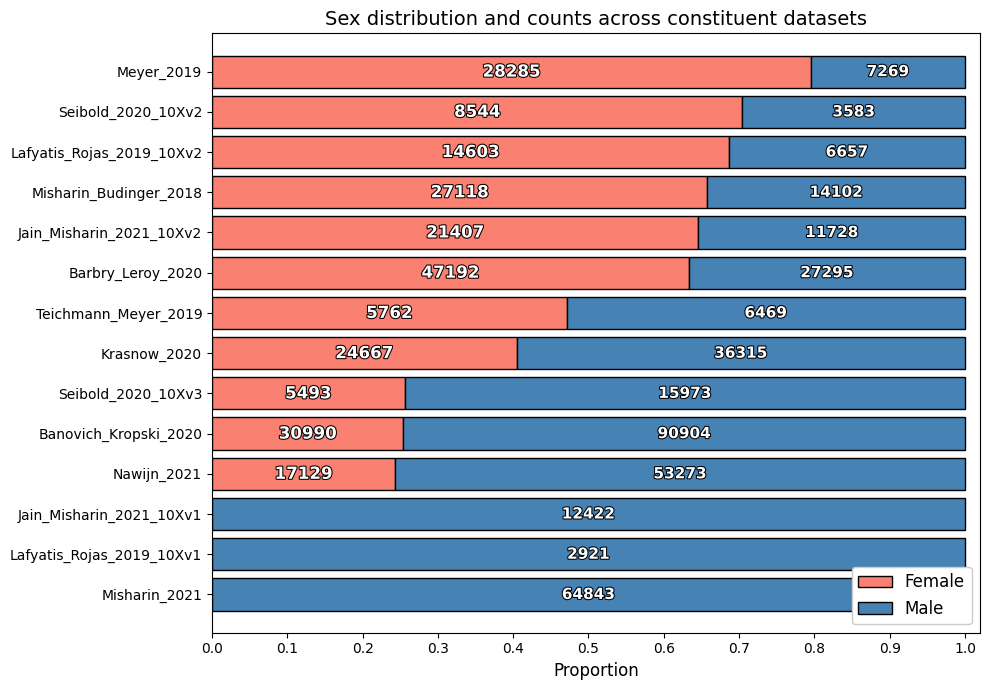

In [10]:
fig, ax = plt.subplots(figsize=(10, len(data)*0.5))

bars_female = ax.barh(data['dataset'], data['female_prop'], color='salmon', label='Female', edgecolor = 'black')
bars_male = ax.barh(data['dataset'], data['male_prop'], left=data['female_prop'], color='steelblue', label='Male', edgecolor = 'black')

# annotate counts inside the bars
for i, (f_count, m_count, f_prop, m_prop) in enumerate(zip(data['female_count'], data['male_count'], data['female_prop'], data['male_prop'])):
    if f_count > 0:
        text = ax.text(f_prop/2, i, str(f_count),
               va='center', ha='center',
               fontsize=12, color='white', fontweight='bold')
        text.set_path_effects([
            path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()
        ])
    if m_count > 0:
        text = ax.text(f_prop + m_prop/2, i, str(m_count),
               va='center', ha='center',
               fontsize=11, color='white', fontweight='bold')
        text.set_path_effects([
            path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()
        ])

ax.set_xlabel('Proportion', fontsize = 12)
ax.set_ylabel(None)
ax.margins(y=0.04) 
ax.set_xlim(0, 1.02)
ax.set_xticks(np.linspace(0,1,11))
ax.tick_params(axis = 'x', labelsize=10)
ax.legend(loc='lower right', fontsize = 12, framealpha=1)
ax.set_title('Sex distribution and counts across constituent datasets', fontsize = 14)

plt.tight_layout()
plt.savefig(f'{path_results}Dataset_Sex_Distrib.png')
plt.show()